AI Assignment: Handwritten Digit Recognition (Image Classification)

Objective :
Develop a machine learning pipeline to classify grayscale images of handwritten digits
(0–9). Implement classical ML models from scratch, carry out image preprocessing and
normalization, and evaluate the models using metrics such as accuracy and confusion
matrix.

In [14]:
# Imports and setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
print("Setup complete!")


Setup complete!


Load MNIST Online + Explore

X shape: (70000, 784) y shape: (70000,)
Class dist:
 [6903 7877 6990 7141 6824 6313 6876 7293 6825 6958]


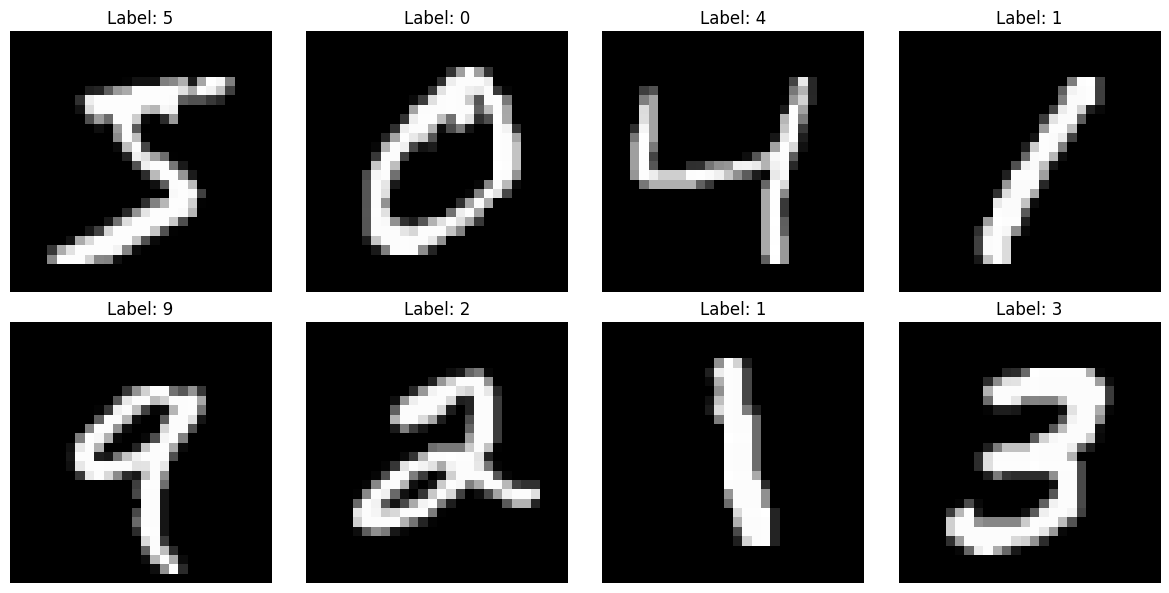

In [17]:
import os
import matplotlib.pyplot as plt # Create directories for submission
os.makedirs('output_images/inputs', exist_ok=True)
os.makedirs('output_images/predictions', exist_ok=True)


from sklearn.datasets import fetch_openml

# Load online MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')  # as_frame=False for dense arrays
X_all, y_all = mnist.data, mnist.target.astype(int)

print("X shape:", X_all.shape, "y shape:", y_all.shape)
print("Class dist:\n", np.bincount(y_all))

# Dense now - plot samples
fig, axes = plt.subplots(2, 4, figsize=(12,6))
for i, ax in enumerate(axes.flat):
    img = X_all[i].reshape(28,28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {y_all[i]}")
    ax.axis('off')
plt.tight_layout()
plt.savefig('output_images/inputs/samples.png')
plt.show()


Preprocess

In [18]:
# Normalize
X_all = X_all / 255.0
# Split (60k train, 10k test)
split_idx = 60000
X_train, X_test = X_all[:split_idx], X_all[split_idx:]
y_train, y_test = y_all[:split_idx], y_all[split_idx:]

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# PCA
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(f"PCA reduced to {X_train.shape[1]} dims")


Train: (60000, 784), Test: (10000, 784)
PCA reduced to 154 dims


Train KNN (sklearn)

In [19]:
knn_params = {'n_neighbors': [3,5,7]}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3)
knn_grid.fit(X_train, y_train)
print("Best k:", knn_grid.best_params_)
knn = knn_grid.best_estimator_


Best k: {'n_neighbors': 3}


Train SVM (sklearn)

In [20]:
svm_params = {'C': [1,10], 'gamma': ['scale', 0.01]}
svm_grid = GridSearchCV(SVC(kernel='rbf'), svm_params, cv=3)
svm_grid.fit(X_train, y_train)  # PCA helps SVM
print("Best params:", svm_grid.best_params_)
svm = svm_grid.best_estimator_


Best params: {'C': 10, 'gamma': 'scale'}


Train Decision Tree

In [ ]:
dt_params = {'max_depth': [10,20], 'min_samples_split': [2,5]}
dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=3)
dt_grid.fit(X_train, y_train)
print("Best params:", dt_grid.best_params_)
dt = dt_grid.best_estimator_

Best params: {'max_depth': 20, 'min_samples_split': 2}


KNN

In [21]:
def knn_scratch(X_tr, y_tr, X_te, k=5):
    preds = []
    for x in X_te:
        dists = np.sqrt(np.sum((X_tr - x)**2, axis=1))
        k_idx = np.argsort(dists)[:k]
        pred = np.bincount(y_tr[k_idx]).argmax()
        preds.append(pred)
    return np.array(preds)

# Test on small subset (full is slow)
sub_n = 5000
y_pred_scratch = knn_scratch(X_train[:sub_n], y_train[:sub_n], X_test[:100], k=5)
print("Scratch KNN acc:", accuracy_score(y_test[:100], y_pred_scratch))


Scratch KNN acc: 0.95


Evaluate All Models

KNN: 0.9722
SVM: 0.9854
DT: 0.2765


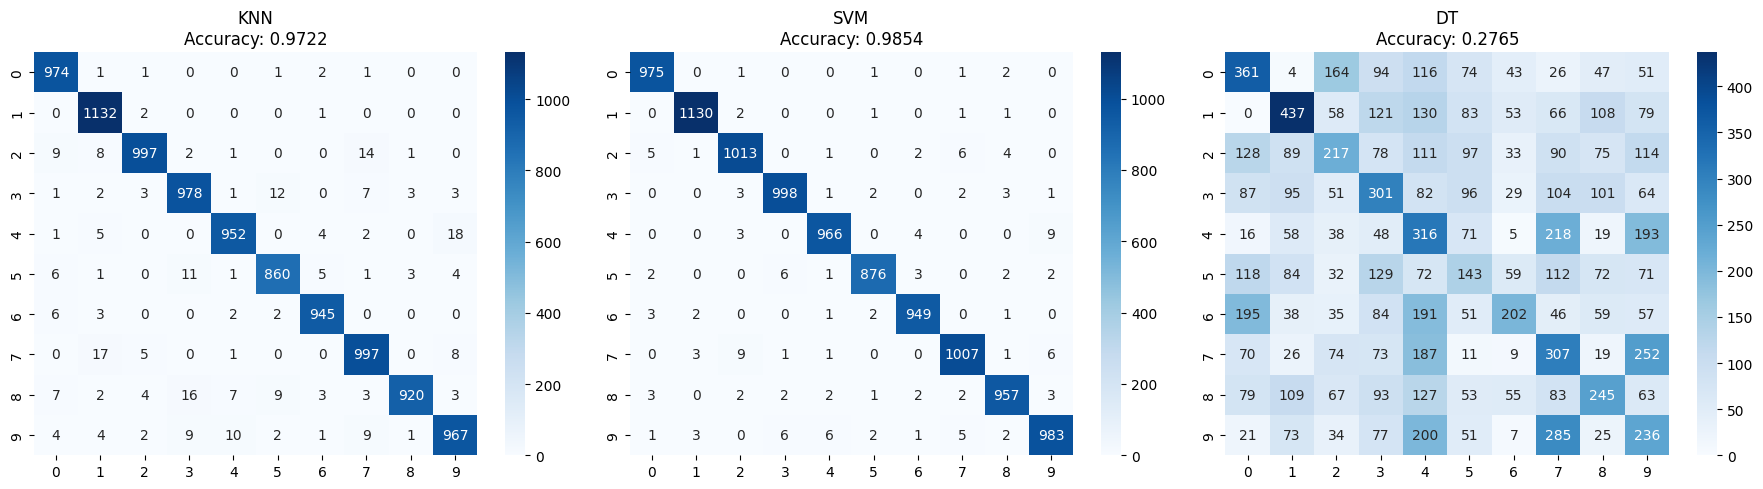

Results: {'KNN': 0.9722, 'SVM': 0.9854, 'DT': 0.2765}


In [35]:
# Evaluation
models = {'KNN': knn, 'SVM': svm, 'DT': dt}
results = {}


fig, axes = plt.subplots(1, 3, figsize=(18,5))

for i, (name, model) in enumerate(models.items()):
    # All models should predict on the single PCA-transformed X_test that was prepared earlier.
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: {acc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"{name}\nAccuracy: {acc:.4f}")

plt.tight_layout()

# Make sure 'folder' is defined. If it's not, set a default.
try:
    _ = folder
except NameError:
    folder = 'output_images/predictions' # Assuming a default path

plt.savefig(f'{folder}/02_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()
print("Results:", results)


Misclassified Images


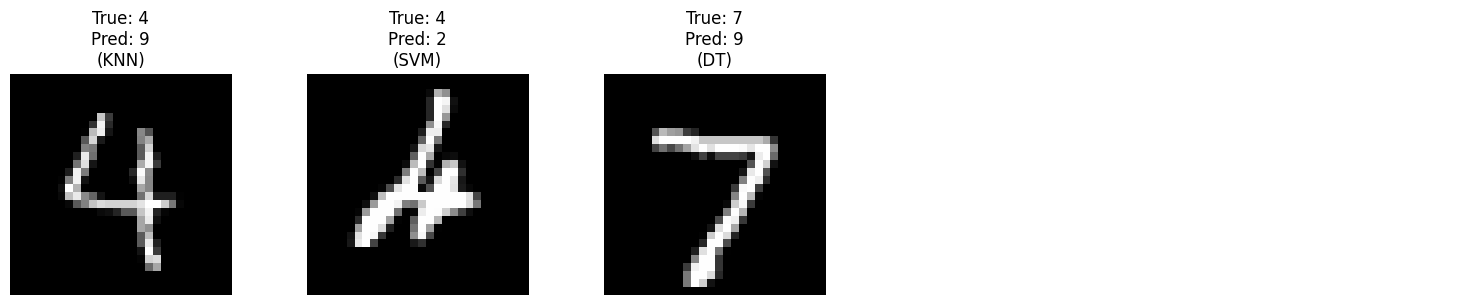

Misclassified images saved!


In [38]:
# Misclassified Images
fig, axes = plt.subplots(1, 5, figsize=(15,3))
mis_idx = 0

for name, model in models.items():
    # All models should predict on the single PCA-transformed X_test that was prepared earlier.
    y_pred = model.predict(X_test)

    # Find first error
    errors = np.where(y_pred != y_test)[0]
    if len(errors) > 0:
        idx = errors[0]  # First misclassification

        # Retrieve original image from X_all for plotting, as X_test is PCA-transformed.
        # split_idx was defined when splitting train/test. X_test starts at split_idx in X_all.
        original_image_idx = split_idx + idx
        img = X_all[original_image_idx].reshape(28,28)

        axes[mis_idx].imshow(img, cmap='gray')
        axes[mis_idx].set_title(f'True: {y_test[idx]}\nPred: {y_pred[idx]}\n({name})')
        axes[mis_idx].axis('off')
        mis_idx += 1
    else:
        print(f"No errors for {name}!")

# Hide unused subplot
for j in range(mis_idx, 5):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig(f'{folder}/03_misclassified.png', dpi=150, bbox_inches='tight')
plt.show()
print("Misclassified images saved!")